In [1]:
# validationf VeRITAS
# we validate how well veritas is doing when we cannot ask too many question
# Typically, we want to evaluate performance in conjunction with a CAT framework
# Conclusion: It seems CAT's question generation is not abest for Veritas
# we can ask similar number of questions, but get much better performance if we 
# generate the questiosn differently, namely questions that not only 
# take into account the goal of getting to diagnosis, but also detection of malingering

In [2]:
def selrandomq(jsondata,num):
    '''
    sel random num number of responses from a json
    '''
    from random import sample 
    subname=list(jsondata.keys())[0]
    keys=list(jsondata[subname].keys())
    return {subname: {k:jsondata[subname][k] for k in sample(keys,num)}}
#selrandomq(fulldata20[0],5)    

In [3]:
import sys
sys.path.append("../") 
from infer_veritas import  *
from truthfinder import *
import gzip

In [10]:
with gzip.open('../response_jsons/validation_cat.pkl.gz', 'rb') as filepath:
    catadata = pickle.load(filepath)
with gzip.open('../response_jsons/validation_index20.pkl.gz', 'rb') as filepath:
    fulldata20 = pickle.load(filepath)
with gzip.open('../response_jsons/validation_ptsd_full.pkl.gz', 'rb') as filepath:
    fulldata = pickle.load(filepath)
Veritas_model_path='../veritas_models/veritas_002.pkl.gz'
with gzip.open(Veritas_model_path, 'rb') as filepath:
    TR= pickle.load(filepath)
vmodel=TR.veritas_model

In [12]:
Rcat=reveal(catadata,vmodel,perturb=0,model_path=False)

ckeck passed


In [13]:
R=reveal(fulldata,vmodel,perturb=0,model_path=False)

ckeck passed


In [14]:
R20=reveal(fulldata20,vmodel,perturb=0,model_path=False)

ckeck passed


In [15]:
pd.DataFrame().assign(cat=[i['score'] for i in Rcat[0]], 
                      r20=[i['score'] for i in R20[0]],
                      full= [i['score'] for i in R[0]]).corr()

,cat,r20,full
cat,1.000000,0.515164,0.615623
r20,0.515164,1.000000,0.920081
full,0.615623,0.920081,1.000000


In [16]:
pd.DataFrame().assign(cat=[i['veritas'] for i in Rcat[0]],
                      r20=[i['veritas'] for i in R20[0]],
                      full= [i['veritas'] for i in R[0]]).corr()

,cat,r20,full
cat,1.000000,0.741406,0.762385
r20,0.741406,1.000000,0.922160
full,0.762385,0.922160,1.000000


In [17]:
pd.DataFrame().assign(cat=[i['lower_threshold'] for i in Rcat[0]], 
                      r20=[i['lower_threshold'] for i in R20[0]],
                      full= [i['lower_threshold'] for i in R[0]]).corr()

,cat,r20,full
cat,1.000000,0.059615,0.248926
r20,0.059615,1.000000,0.827879
full,0.248926,0.827879,1.000000


In [18]:
pd.DataFrame([(int(i['subject_id'][-1]),i['lower_threshold']) for i in Rcat[0]])#.corr()

,0,1
0,0,0.850706
1,0,1.381306
2,0,1.734831
3,0,1.642153
4,0,0.983170
...,...,...
299,1,1.963810
300,1,0.810242
301,0,1.269050
302,0,1.784822


In [19]:
def malingering(lower_threshold,veritas,upper,C0=1,C1=0.76,C2=1.35):
    M=False
    if (lower_threshold < C0) and (upper > C2):
        M=True
    if (veritas > C1) and (upper > C2):
        M=True
    return int(M)

def malingeringCAT(lower_threshold,veritas,theta,C0=1,C1=0.76,C2=0):
    M=False
    if (lower_threshold < C0) and (theta > C2):
        M=True
    if (veritas > C1) and (theta > C2):
        M=True
    return int(M)

In [41]:
dxv=[i['score']>1.35 for i in R[0]]
dxv20=[i['score']>1.35 for i in R20[0]]
dxRcat=[i['score']>1.35 for i in Rcat[0]]
theta=[x[0] for x in pd.read_csv('../response_jsons/cattheta304.csv',index_col=0).values.astype(float)]
mgcat=[malingeringCAT(i['lower_threshold'],i['veritas'],j) for i,j in zip(Rcat[0],theta)]
mgRcat=[malingering(i['lower_threshold'],i['veritas'],i['score']) for i in Rcat[0]]
mg20=[malingering(i['lower_threshold'],i['veritas'],i['score']) for i in R20[0]]
mg=[malingering(i['lower_threshold'],i['veritas'],i['score']) for i in R[0]]
k=[i['lower_threshold'] for i in R[0]]
v=[i['veritas'] for i in R[0]]
s=[i['score'] for i in R[0]]

dxcat=[x>0 for x in theta]

In [42]:
Dcat=pd.DataFrame([(int(i['subject_id'][-1]),malingering(i['lower_threshold'],i['veritas'],i['score'])) for i in R[0]],columns=['dx','mg'])
print(Dcat[(Dcat.dx==1) & (Dcat.mg==1)].index.size)
Dcat=Dcat.assign(dxv20=dxv20,dxv=dxv,theta=theta,mgcat=mgcat,k=k,v=v,dxcat=dxcat,mg20=mg20,mgRcat=mgRcat,s=s,dxRcat=dxRcat)#.corr()
Dcat.corr()

9


,dx,mg,dxv20,dxv,theta,mgcat,k,v,dxcat,mg20,mgRcat,s,dxRcat
dx,1.000000,0.278092,0.491854,0.591414,0.551681,0.218962,-0.546329,-0.644564,0.526768,0.355576,0.145930,0.614569,0.287096
mg,0.278092,1.000000,0.334929,0.299901,0.234841,0.075275,-0.413563,-0.380560,0.240460,0.414159,0.113055,0.401578,0.203240
dxv20,0.491854,0.334929,1.000000,0.747829,0.636366,0.295771,-0.721486,-0.733436,0.667323,0.610755,0.247572,0.774441,0.479940
dxv,0.591414,0.299901,0.747829,1.000000,0.724230,0.458563,-0.808536,-0.819069,0.801797,0.494567,0.315283,0.877350,0.520306
theta,0.551681,0.234841,0.636366,0.724230,1.000000,0.477364,-0.771767,-0.878979,0.787155,0.377283,0.216613,0.878931,0.427508
mgcat,0.218962,0.075275,0.295771,0.458563,0.477364,1.000000,-0.417715,-0.456810,0.625365,0.217824,0.498866,0.479026,0.317715
k,-0.546329,-0.413563,-0.721486,-0.808536,-0.771767,-0.417715,1.000000,0.893667,-0.775630,-0.523009,-0.267442,-0.926411,-0.497581
v,-0.644564,-0.380560,-0.733436,-0.819069,-0.878979,-0.456810,0.893667,1.000000,-0.836917,-0.521186,-0.233868,-0.927784,-0.480097
dxcat,0.526768,0.240460,0.667323,0.801797,0.787155,0.625365,-0.775630,-0.836917,1.000000,0.414563,0.258572,0.835251,0.482469
mg20,0.355576,0.414159,0.610755,0.494567,0.377283,0.217824,-0.523009,-0.521186,0.414563,1.000000,0.194562,0.504447,0.323277


In [22]:
Dcat.sum()

dx         86.000000
mg          9.000000
dxv20      65.000000
dxv        77.000000
theta    -131.983000
mgcat      17.000000
k         407.613339
v         238.502814
dxcat     105.000000
mg20       28.000000
mgRcat     37.000000
s         316.885410
dxRcat     61.000000
dtype: float64

In [23]:
pd.DataFrame([(int(i['subject_id'][-1]),malingering(i['lower_threshold'],i['veritas'],i['score'])) for i in R20[0]]).corr()

,0,1
0,1.000000,0.355576
1,0.355576,1.000000


In [24]:
rf20=pd.DataFrame([(int(i['subject_id'][-1]),malingering(i['lower_threshold'],i['veritas'],i['score'])) for i in R20[0]],columns=['dx','mg'])
rf20.corr()

,dx,mg
dx,1.000000,0.355576
mg,0.355576,1.000000


In [25]:
rf20[rf20.dx==1].index.size

86

In [26]:
rf20[(rf20.dx==1) & (rf20.mg==1)]

,dx,mg
5,1,1
14,1,1
20,1,1
23,1,1
36,1,1
39,1,1
58,1,1
63,1,1
88,1,1
90,1,1


In [27]:
rf20[(rf20.mg==1)].index.size

28

In [28]:
rf=pd.DataFrame([(int(i['subject_id'][-1]),malingering(i['lower_threshold'],i['veritas'],i['score'])) for i in R[0]],columns=['dx','mg'])
rf.corr()

,dx,mg
dx,1.000000,0.278092
mg,0.278092,1.000000


In [29]:
rf[(rf.dx==1) & (rf.mg==1)]

,dx,mg
14,1,1
58,1,1
86,1,1
90,1,1
103,1,1
213,1,1
238,1,1
246,1,1
291,1,1


In [30]:
rf[(rf.mg==1)].index.size

9

In [31]:
rfcat=pd.DataFrame([(int(i['subject_id'][-1]),malingering(i['lower_threshold'],i['veritas'],i['score'])) for i in Rcat[0]],columns=['dx','mg'])
rfcat.corr()

,dx,mg
dx,1.00000,0.14593
mg,0.14593,1.00000


In [32]:
rfcat[(rfcat.dx==1) & (rfcat.mg==1)]#.index.size

,dx,mg
5,1,1
38,1,1
39,1,1
57,1,1
58,1,1
60,1,1
63,1,1
103,1,1
152,1,1
221,1,1


In [33]:
rfcat[(rfcat.mg==1)].index.size

37

In [34]:
from sklearn import metrics
from zedstat import zedstat
from jupyterthemes import jtplot
import pylab as plt
jtplot.style()

In [35]:
fpr, tpr, thresholds = metrics.roc_curve(rf.dx.values,[1/(1+ (1/x['score'])) for x in R[0]], pos_label=1)
ff=pd.DataFrame(tpr,fpr,columns=['tpr']).assign(threshold=thresholds)
ff.index.name='fpr'
zt=zedstat.processRoc(df=ff.reset_index(),
                      order=3, 
                      total_samples=304,
                      positive_samples=86,
                      alpha=0.01,
                      prevalence=0.5)
zt.smooth(STEP=0.001)
zt.allmeasures(interpolate=True)
zt.usample(precision=3)

fpr20, tpr20, thresholds20 = metrics.roc_curve(rf.dx.values,[1/(1+ (1/x['score'])) for x in R20[0]], pos_label=1)
ff20=pd.DataFrame(tpr20,fpr20,columns=['tpr']).assign(threshold=thresholds20)
ff20.index.name='fpr'
zt20=zedstat.processRoc(df=ff20.reset_index(),
                      order=3, 
                      total_samples=304,
                      positive_samples=86,
                      alpha=0.01,
                      prevalence=0.5)
zt20.smooth(STEP=0.001)
zt20.allmeasures(interpolate=True)
zt20.usample(precision=3)

fprcat, tprcat, thresholdscat = metrics.roc_curve(rfcat.dx.values,[1/(1+ (1/x['score'])) for x in Rcat[0]], pos_label=1)
ffcat=pd.DataFrame(tprcat,fprcat,columns=['tpr']).assign(threshold=thresholdscat)
ffcat.index.name='fpr'
ztcat=zedstat.processRoc(df=ffcat.reset_index(),
                      order=3, 
                      total_samples=304,
                      positive_samples=86,
                      alpha=0.01,
                      prevalence=0.5)
ztcat.smooth(STEP=0.001)
ztcat.allmeasures(interpolate=True)
ztcat.usample(precision=3)

CATTHETA=pd.read_csv('../response_jsons/cattheta304.csv',index_col=0).values
fprcat0, tprcat0, thresholdscat0 = metrics.roc_curve(rfcat.dx.values,CATTHETA, pos_label=1)
ffcat0=pd.DataFrame(tprcat0,fprcat0,columns=['tpr']).assign(threshold=thresholdscat0)
ffcat0.index.name='fpr'
ztcat0=zedstat.processRoc(df=ffcat0.reset_index(),
                      order=3, 
                      total_samples=304,
                      positive_samples=86,
                      alpha=0.01,
                      prevalence=0.5)
ztcat0.smooth(STEP=0.001)
ztcat0.allmeasures(interpolate=True)
ztcat0.usample(precision=3)

,tpr,ppv,acc,npv,LR+,LR-,threshold
fpr,,,,,,,
0.000,0.000000,0.911834,0.500000,0.500000,13.934402,1.000000,3.2880
0.001,0.013953,0.911413,0.506518,0.503521,14.061892,0.986843,3.1263
0.002,0.027907,0.910993,0.513036,0.507042,14.189382,0.973686,2.9646
0.003,0.041860,0.910573,0.519554,0.510562,14.316872,0.960530,2.8029
0.004,0.055814,0.910153,0.526072,0.514083,14.444362,0.947373,2.6412
...,...,...,...,...,...,...,...
0.996,1.000000,0.455627,0.501998,1.323023,1.005155,0.000000,0.0000
0.997,1.000000,0.455170,0.501498,1.324485,1.003866,0.000000,0.0000
0.998,1.000000,0.454712,0.500999,1.325947,1.002577,0.000000,0.0000


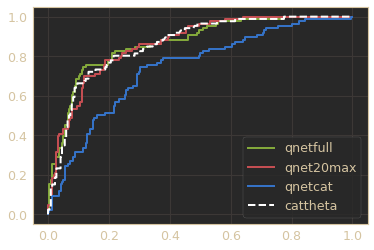

In [36]:
plt.plot(fpr,tpr,'g',lw=2)
plt.plot(fpr20,tpr20,'r',lw=2)
plt.plot(fprcat,tprcat,'b',lw=2)
#plt.plot(fprrnd,tprrnd,'m',lw=1)
plt.plot(fprcat0,tprcat0,'--w',lw=2)
plt.gca().legend(['qnetfull','qnet20max','qnetcat','cattheta'])

full:  (0.8826686046511627, 0.9419033220709785, 0.8234569521169444) r20:  (0.8782151162790698, 0.9330424823835122, 0.8234507319066535) rcat:  (0.7654883720930232, 0.8529447261950202, 0.6781644094316119) cat0:  (0.8738720930232557, 0.9321944097985972, 0.8156089531527262)


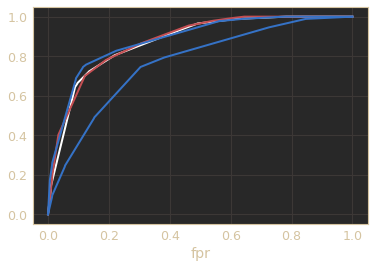

In [37]:
ztcat0.get().tpr.plot(style='-w',lw=2)
zt20.get().tpr.plot(style='-r',lw=2)
zt.get().tpr.plot(style='-b',lw=2)
ztcat.get().tpr.plot(style='-b',lw=2)
print('full: ',zt.auc(),'r20: ',zt20.auc(), 'rcat: ',ztcat.auc(), 'cat0: ',ztcat0.auc())


In [38]:
zt.scoretoprobability(1.3)

0.9972477064220184

In [39]:
zt20.scoretoprobability(1.3)

0.9901703800786368

In [40]:
a=ztcat0.get()
a[a.ppv>.9].tail(1)

,tpr,ppv,acc,npv,LR+,LR-,threshold
fpr,,,,,,,
0.025,0.240801,0.900397,0.607916,0.572008,13.615078,0.772523,1.424519
